In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Using BERT and Tensorflow 2.0, we will write simple code to classify emails as spam or not spam. BERT will be used to generate sentence encoding for all emails and after that we will use a simple neural network with one drop out layer and one output layer. 


In [2]:
edf= pd.read_csv("SMSCollection.csv")

In [3]:
edf.head()

,Class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
edf.groupby('Class').describe()     

# we see there is imbalance in spam and ham class. So we can use downsampling technique to balance the data

sms                                                               
      count unique                                                top freq
Class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [5]:
edf['Class'].value_counts()        


ham     4825
spam     747
Name: Class, dtype: int64

In [6]:
747/4825

# so here we see that 15% of the email are spam. So we will randomly pick any 747 emails from 
# ham and discard rest of them. that way we will have equal number of spam and ham. 


0.15481865284974095

# We have other methods to get balanced df but here we will use downsampling. 
for that we split ham and spam to 2 different df's

In [7]:
edf_spam= edf[edf['Class']== 'spam']
edf_spam.shape

(747, 2)

In [8]:
edf_ham= edf[edf['Class'] == 'ham']
edf_ham.shape

(4825, 2)

In [9]:
edf_ham_downsampled= edf_ham.sample(edf_spam.shape[0])   # here im equalizing ham with the shape of spam
edf_ham_downsampled.shape

(747, 2)

In [10]:
#  now since I have both in equal shape, will now concate them 

edf_balanced= pd.concat([edf_spam, edf_ham_downsampled])
edf_balanced.shape

(1494, 2)

In [11]:
edf_balanced.Class.value_counts()  

# for now 747 ham is taken in and others are discarded but thats actually not good,its just for practice purpose

spam    747
ham     747
Name: Class, dtype: int64

In [12]:
edf_balanced.sample(5)           # this 'sample' will randomly pick data

,Class,sms
4629,spam,Todays Voda numbers ending with 7634 are selec...
225,spam,"500 New Mobiles from 2004, MUST GO! Txt: NOKIA..."
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...
3877,ham,did u get that message
3836,ham,I'm thinking that chennai forgot to come for a...


In [13]:
#  lets create a new col. We can create a new col with the original df by applying a function within that
# here we are applying labmda function. 

edf_balanced['spam']= edf_balanced['Class'].apply(lambda x: 1 if x== 'spam' else 0)
edf_balanced.sample(5)

,Class,sms,spam
4903,spam,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...,1
3463,spam,Bloomberg -Message center +447797706009 Why wa...,1
869,spam,Hello. We need some posh birds and chaps to us...,1
5096,ham,But i'm really really broke oh. No amount is t...,0
2146,spam,Sunshine Hols. To claim ur med holiday send a ...,1


In [14]:
#  now the df is ready. we need to split our df with train and test data

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(edf_balanced['sms'], edf_balanced['spam'], stratify= edf_balanced['spam'])

# we are using startify so that in the train and test the distribution of categories are equal

In [15]:
x_train.head(4)

1650                       ITS A LAPTOP TAKE IT WITH YOU.
424     URGENT! Your Mobile number has been awarded wi...
2666                       R u meeting da ge at nite tmr?
591     For ur chance to win a £250 wkly shopping spre...
Name: sms, dtype: object

# Now we will start with BERT model

In [16]:
# these are the trained models that are already availble in tensorflow hub website . 
# we are just copying the url for preprocessing and encoder to download those trained models 

bert_preprocessed= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

# this will download the trained models to ur local system


In [17]:
# below is the example im trying with trained bert models

# sentence= "500$ discount on purchase of 2500"bert_preprocessed
# prepr_text= bert_preprocessed(sentence)
# ouput= bert_encoder(prepr_text)['pooled_output']

In [19]:
# lets first define our bert layers-- 
text_input= tf.keras.layers.Input(shape=(), dtype=tf.string, name= "text")
preprocessed_text= bert_preprocessed(text_input)
outputs= bert_encoder(preprocessed_text)


# lets define our Neural network layers
l= tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l= tf.keras.layers.Dense(1, activation= 'sigmoid', name= 'ouput')(l)

# contruct final model
model= tf.keras.Model(inputs=[text_input], outputs= [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

# from the above line we see 769 parameters are trainable ie, 768 + 1 dense neuron. rest of the parameters are nontrainable as its pretrained already

In [23]:
#  now we need to compile the model

METRICS= [
    tf.keras.metrics.BinaryAccuracy(name= 'accuracy'),
    tf.keras.metrics.Precision(name= 'precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer= 'adam',
             loss= 'binary_crossentropy',
             metrics= METRICS)                        


# METRICS willnot have any impact on actual training coz this is driven by loss function, 
# METRICS is just to have an idea on how our training is working. 

In [25]:
#  now everything is ready, lets fit the model 

model.fit(x_train, y_train, epochs=1)    #just give2,3 epochs thats enough

# Note since we have balanced the dataset we can relay on accuracy but in general when 
# its imbalanced dataset we cant rely on aacuracy

35/35 [==============================] - 226s 6s/step - loss: 0.4271 - accuracy: 0.8446 - precision: 0.8351 - recall: 0.8589


In [26]:
#  we then evaluate
model.evaluate(x_test, y_test)    # on test set I get more accuarcy but its fine coz I trained only for 3epochs

12/12 [==============================] - 83s 7s/step - loss: 0.3906 - accuracy: 0.8957 - precision: 0.9512 - recall: 0.8342


[0.39059120416641235,
 0.8957219123840332,
 0.9512194991111755,
 0.8342245817184448]

In [32]:
# y_pred= model.predict(x_test)      # interupted teh kernel coz it was again running (too much computational power so stopped)
# y_pred[:5]

In [28]:
y_pred= y_pred.flatten()            # since we have 2dim array we will flatten this to 1D

In [29]:
y_pred[:5]               # we have it in 1D

array([0.36089966, 0.06463287, 0.5514777 , 0.36435336, 0.74174947],
      dtype=float32)

In [33]:
#  now we know that sigmoid if its more that 0.5 then its spam else its ham
# so we can write that condition to get more resize o/p 

import numpy as np
y_pred= np.where(y_pred > 0.5, 1, 0)
y_pred

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,

In [35]:
#  using y_test and y_pred we can plot confussion matrix 

from sklearn.metrics import confusion_matrix, classification_report

cm= confusion_matrix(y_test, y_pred)
cm

array([[179,   8],
       [ 31, 156]], dtype=int64)

Text(33.0, 0.5, 'Actual')

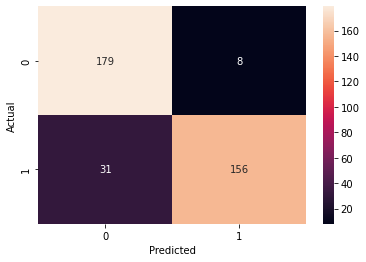

In [37]:
#  the same above matrix we can get in seaborn also so that its more apealing

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       187
           1       0.95      0.83      0.89       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



# Inference - means checking with examples or real data

In [49]:
reviews= [
    'WINNER! As a valued network customer you have been selected to receivea £900 prize reward!',
    'Enter a chance to win $5000, hurry up offer valid till tommorow',
    'Your 500 free text messages are valid till dec 2022',
    'Hey! are you attending confenrence call tomorow',
    "Hi Nicole, How rae doing?"
]

model.predict(reviews)                            # this is giving me right o/p for the last 2 but for first 3 its close to 0.5

1/1 [==============================] - 1s 939ms/step


array([[0.39843616],
       [0.48509508],
       [0.38661397],
       [0.10114011],
       [0.262087  ]], dtype=float32)

In [42]:
sentence= ["500$ discount on purchase of 2500"]
model.predict(sentence)                  # tihs is more than 0.5 so its predicting that its spam

1/1 [==============================] - 0s 272ms/step


array([[0.5541178]], dtype=float32)